# PSO Fitting Testing

In [1]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

## Do 12-005 S2

Removing means (['major_axis_length: 58.04', 'minor_axis_length: 18.48']) and scaling standard deviations (['major_axis_length: 29.93', 'minor_axis_length: 9.21']) to be 1


<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

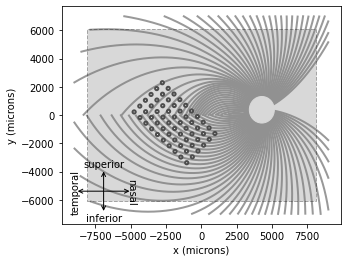

In [2]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2)
model.xystep=0.5

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape

estimator = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, resize=True)
search_params = {
    'a5' : (-1, 5),
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=50, has_loss_function=True)

y_moments = estimator.precompute_moments(y)
model.build()
model.plot()
implant.plot()

In [ ]:
estimator.score(x, y_moments)
opt.fit(x, y_moments)
estimator.score(x, y_moments)

rho=200.000000, axlambda=200.000000, a5=1.081200, a6=-0.353380, null_props=0.0, score=5.879686, mses: ['major_axis_length: 1.56', 'minor_axis_length: 4.32']
rho=567.320600, axlambda=1670.260107, a5=1.128286, a6=-0.410358, null_props=0.0, score=90.286533, mses: ['major_axis_length: 9.551', 'minor_axis_length: 80.735']
rho=813.612681, axlambda=1492.475009, a5=-0.263333, a6=1.329166, null_props=0.0, score=90.271717, mses: ['major_axis_length: 8.292', 'minor_axis_length: 81.979']
rho=985.600975, axlambda=1654.127600, a5=1.815573, a6=-1.269466, null_props=0.0, score=376.895656, mses: ['major_axis_length: 32.49', 'minor_axis_length: 344.405']
rho=180.942998, axlambda=548.803297, a5=0.475025, a6=0.406219, null_props=0.0, score=3.461812, mses: ['major_axis_length: 1.221', 'minor_axis_length: 2.241']
rho=779.972362, axlambda=992.635192, a5=-0.620506, a6=1.775632, null_props=0.0, score=64.334205, mses: ['major_axis_length: 4.416', 'minor_axis_length: 59.919']
rho=172.472242, axlambda=1858.396336

In [ ]:
params1 = estimator.get_params()

In [ ]:
params1

In [ ]:
import random
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
estimator.set_params(params1)
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample([i for i in range(len(x))], 10)):
    axes[plt_idx, 0].imshow(resize(center_image(preds[img_idx] > 1), y[img_idx].shape), cmap="gray")
    props = measure.regionprops(measure.label(resize(center_image(preds[img_idx] > 1), y[img_idx].shape)))
    axes[plt_idx, 0].set_title("Predicted. Area:%.2f, Ecc:%.2f" % (props[0].area, props[0].eccentricity))
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    props = measure.regionprops(measure.label(center_image(y[img_idx])))
    prop = max(props, key = lambda x : x.area)
    axes[plt_idx, 1].set_title("Actual. Area:%.2f, Ecc:%.2f" % (prop.area, prop.eccentricity))
fig.show()
estimator.score(x, y_moments)

### Fit size model first

a5=0.224807, a6=0.718991


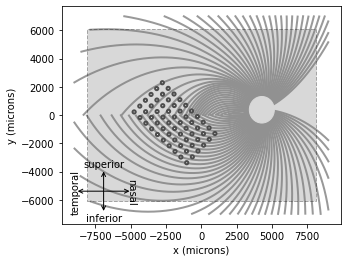

In [11]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2)
model.xystep=0.5

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']

img_shape = y[0].shape
#change xystep to make images the same dimension
# if (model.xrange[1] - model.xrange[0]) / img_shape[1] == (model.yrange[1] - model.yrange[0]) / img_shape[0]:
#     model.xystep = (model.xrange[1] - model.xrange[0]) / img_shape[1]
# else:
#     print("Couldnt find correct xystep")
# CHANGING relative_weight will be important
# relative_weight=92890
relative_weight = 2e-6
estimator = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, relative_weight=relative_weight, resize=True)
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=50, has_loss_function=True)

y_moments = estimator.precompute_moments(y)
model.build()
model.plot()
implant.plot()
estimator.fit_size_model(x['amp1'], y)

In [12]:
estimator.score(x, y)
opt.fit(x, y)
estimator.score(x, y)

rho=200.000000, axlambda=200.000000, a5=0.224807, a6=0.718991, null_props=0.0, score=0.595070, mses: [2.02e+05 1.91e-01], weighted: [0.4  0.19]
rho=505.638998, axlambda=515.754476, a5=0.224807, a6=0.718991, null_props=0.0, score=38.911224, mses: [1.94e+07 2.03e-01], weighted: [38.71  0.2 ]
rho=634.485393, axlambda=936.590801, a5=0.224807, a6=0.718991, null_props=0.0, score=122.570053, mses: [6.12e+07 1.33e-01], weighted: [122.44   0.13]
rho=966.938406, axlambda=1965.065307, a5=0.224807, a6=0.718991, null_props=0.0, score=741.791465, mses: [3.71e+08 9.73e-02], weighted: [7.42e+02 9.73e-02]
rho=90.560083, axlambda=1395.269075, a5=0.224807, a6=0.718991, null_props=0.0, score=0.937871, mses: [4.51e+05 3.62e-02], weighted: [0.9  0.04]
rho=988.460243, axlambda=1065.575321, a5=0.224807, a6=0.718991, null_props=0.0, score=623.778316, mses: [3.12e+08 2.01e-01], weighted: [6.24e+02 2.01e-01]
rho=809.785889, axlambda=1946.309381, a5=0.224807, a6=0.718991, null_props=0.0, score=416.943299, mses: [

0.37014149589149564

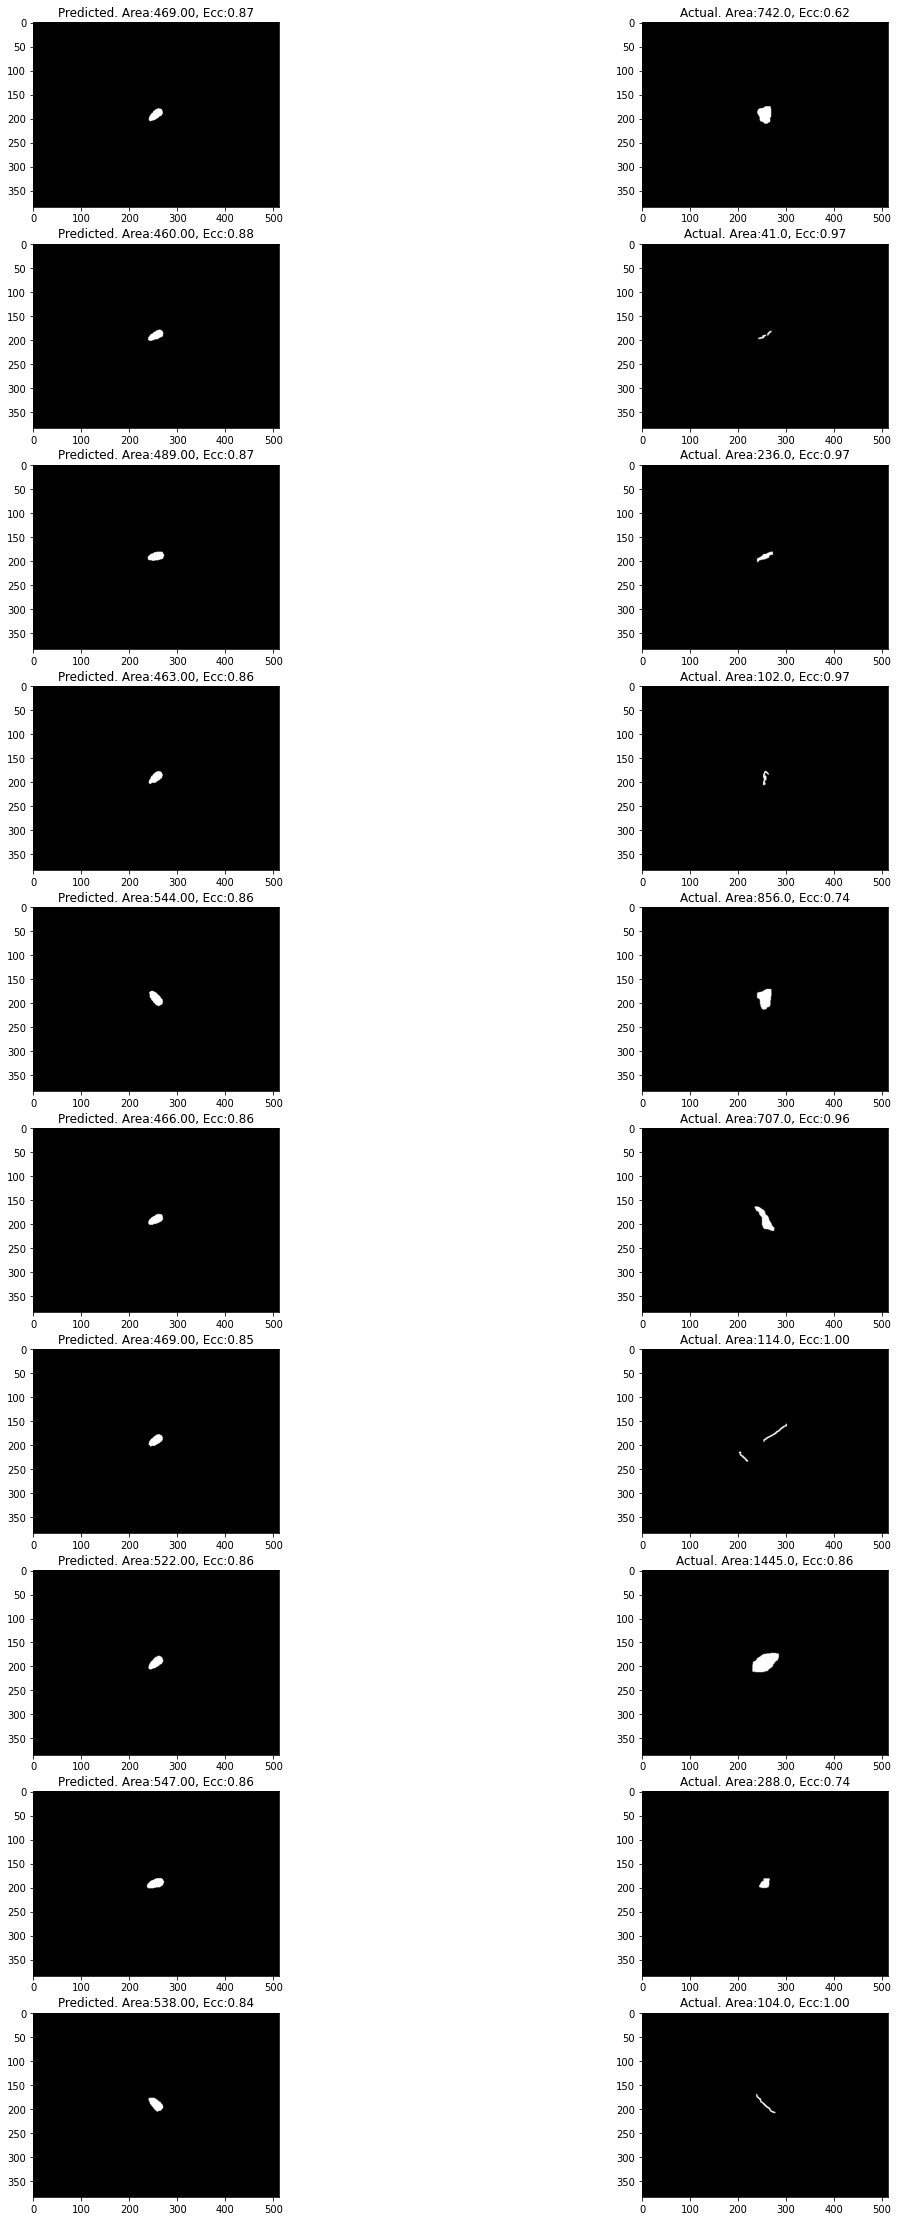

In [13]:
import random
from pulse2percept.utils import center_image, trim_image, scale_image
from skimage import measure
from skimage.transform import resize
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample([i for i in range(len(x))], 10)):
    axes[plt_idx, 0].imshow(resize(center_image(preds[img_idx] > 1), y[img_idx].shape), cmap="gray")
    props = measure.regionprops(measure.label(resize(center_image(preds[img_idx] > 1), y[img_idx].shape)))
    axes[plt_idx, 0].set_title("Predicted. Area:%.2f, Ecc:%.2f" % (props[0].area, props[0].eccentricity))
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    props = measure.regionprops(measure.label(center_image(y[img_idx])))
    prop = max(props, key = lambda x : x.area)
    axes[plt_idx, 1].set_title("Actual. Area:%.2f, Ecc:%.2f" % (prop.area, prop.eccentricity))
fig.show()
estimator.score(x, y_moments)

In [70]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
s.fit(y_moments)

array([560.18,   0.87])

In [73]:
str(x.iloc[0:2])

'   amp1  freq  pdur electrode1\n0   1.5  20.0  0.45         A2\n1   1.5  20.0  0.45         A2'

### New relative weight

In [49]:
model.size_model(20, 1, 0.45)

0.7235124302788845

In [24]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2)
model.xystep=0.5

# CHANGING relative_weight will be very important
estimator = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, relative_weight=1e-3)
search_params = {
    'a5' : (-10, 10),
    'a6': (-10, 10),
    'rho': (10, 300),
    'axlambda': (10, 500)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=40, has_loss_function=True)

In [25]:
estimator.score(x, y)
opt.fit(x, y)

rho=200.000000, axlambda=200.000000, a5=1.081200, a6=-0.353380, score=693.508954
rho=119.405015, axlambda=290.160659, a5=-8.649741, a6=8.138974, score=4.449643
rho=268.360425, axlambda=291.994725, a5=-8.675122, a6=-2.844592, score=4.446453
rho=214.634367, axlambda=53.756793, a5=9.574124, a6=8.458668, score=24795.643257
rho=288.550622, axlambda=384.022614, a5=-0.921475, a6=-9.714843, score=4.269401
rho=280.542000, axlambda=15.847194, a5=2.986445, a6=-5.845247, score=478.808383
rho=286.562400, axlambda=136.919117, a5=-8.408391, a6=1.512653, score=4.911887
rho=58.736304, axlambda=239.650781, a5=2.324339, a6=6.731801, score=27.766219
rho=208.928120, axlambda=42.480946, a5=-5.932344, a6=0.040051, score=5.301103
rho=156.795653, axlambda=127.928806, a5=1.799180, a6=0.873852, score=200.060091
rho=69.776822, axlambda=155.988823, a5=8.810395, a6=7.432929, score=251.096003
rho=279.694531, axlambda=150.255523, a5=2.758443, a6=-5.615327, score=477.415187
rho=37.327878, axlambda=433.272740, a5=3.003

ParticleSwarmOptimizer(estimator=BiphasicAxonMapEstimator, 
                       has_loss_function=True, 
                       max_iter=100, min_func=0.01, 
                       min_step=0.01, search_params=dict, 
                       swarm_size=40, verbose=False)

In [28]:
params2 = estimator.get_params()

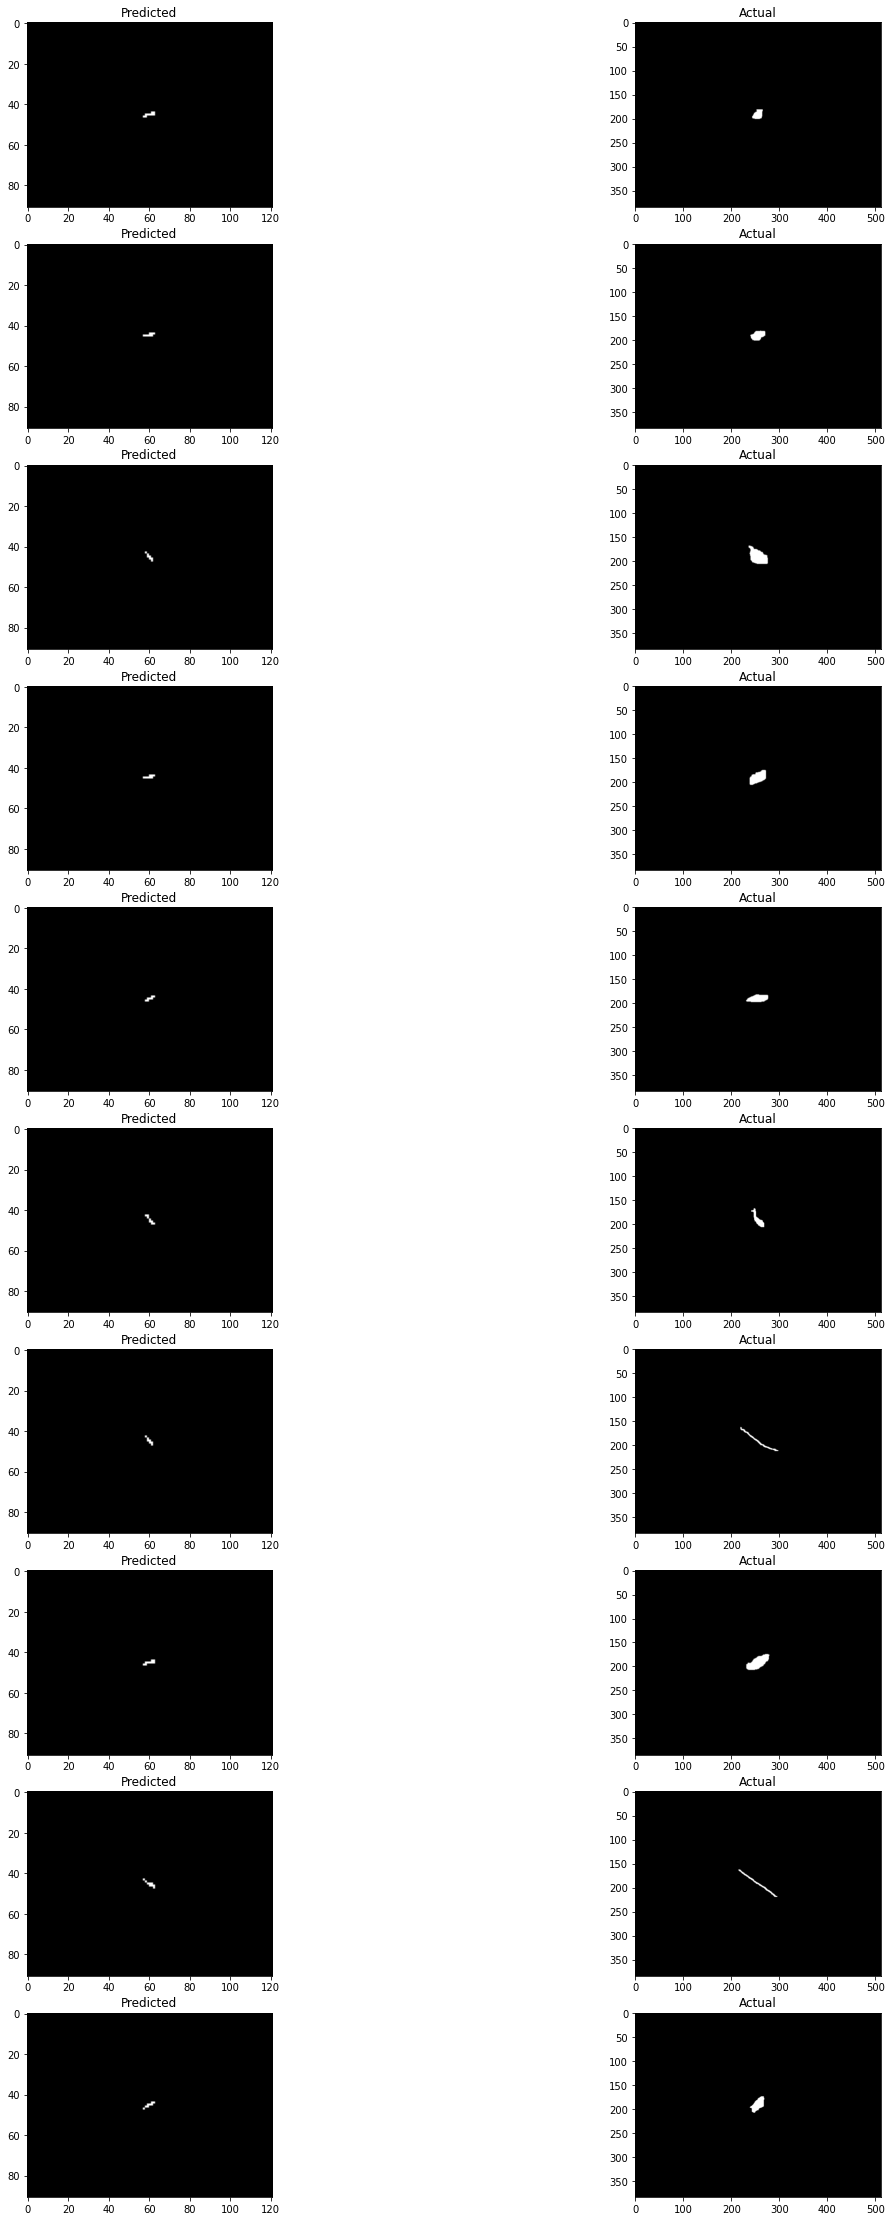

In [26]:
import random
from pulse2percept.utils import center_image
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample([i for i in range(len(x))], 10)):
    axes[plt_idx, 0].imshow(center_image(preds[img_idx] > 1), cmap="gray")
    axes[plt_idx, 0].set_title("Predicted")
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    axes[plt_idx, 1].set_title("Actual")
fig.show()

In [38]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2)
model.xystep=0.5

# CHANGING relative_weight will be very important
estimator = shapes.BiphasicAxonMapEstimator(implant=implant, model=model, relative_weight=1e-1)
search_params = {
    'a5' : (-10, 10),
    'a6': (-10, 10),
    'rho': (10, 300),
    'axlambda': (10, 500)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=100, swarm_size=40, has_loss_function=True)

In [39]:
estimator.score(x, y)
opt.fit(x, y)

rho=200.000000, axlambda=200.000000, a5=1.081200, a6=-0.353380, score=69327.848682
rho=193.577593, axlambda=47.677672, a5=4.256859, a6=6.567921, score=5326.962234
rho=38.017653, axlambda=218.617322, a5=8.910464, a6=8.488114, score=24.807352
rho=40.558917, axlambda=56.590347, a5=3.803893, a6=-8.757717, score=4.897108
rho=101.919522, axlambda=449.096874, a5=-9.222855, a6=6.334293, score=4.193235
rho=205.181154, axlambda=397.760362, a5=7.001592, a6=8.553083, score=15534.331570
rho=60.819996, axlambda=213.011714, a5=2.049065, a6=-7.799924, score=4.347842
rho=102.038645, axlambda=374.602323, a5=5.387349, a6=8.979625, score=887.219739
rho=229.441370, axlambda=294.347363, a5=9.513505, a6=-1.404633, score=15129.164199
rho=139.337279, axlambda=286.959204, a5=-2.082693, a6=-4.703043, score=4.452995
rho=99.210210, axlambda=485.697010, a5=2.324139, a6=4.519439, score=246.383648
rho=209.834735, axlambda=496.761618, a5=1.148648, a6=6.999069, score=3470.752606
rho=112.610371, axlambda=152.161983, a5=

ParticleSwarmOptimizer(estimator=BiphasicAxonMapEstimator, 
                       has_loss_function=True, 
                       max_iter=100, min_func=0.01, 
                       min_step=0.01, search_params=dict, 
                       swarm_size=40, verbose=False)

In [40]:
params3 = estimator.get_params()

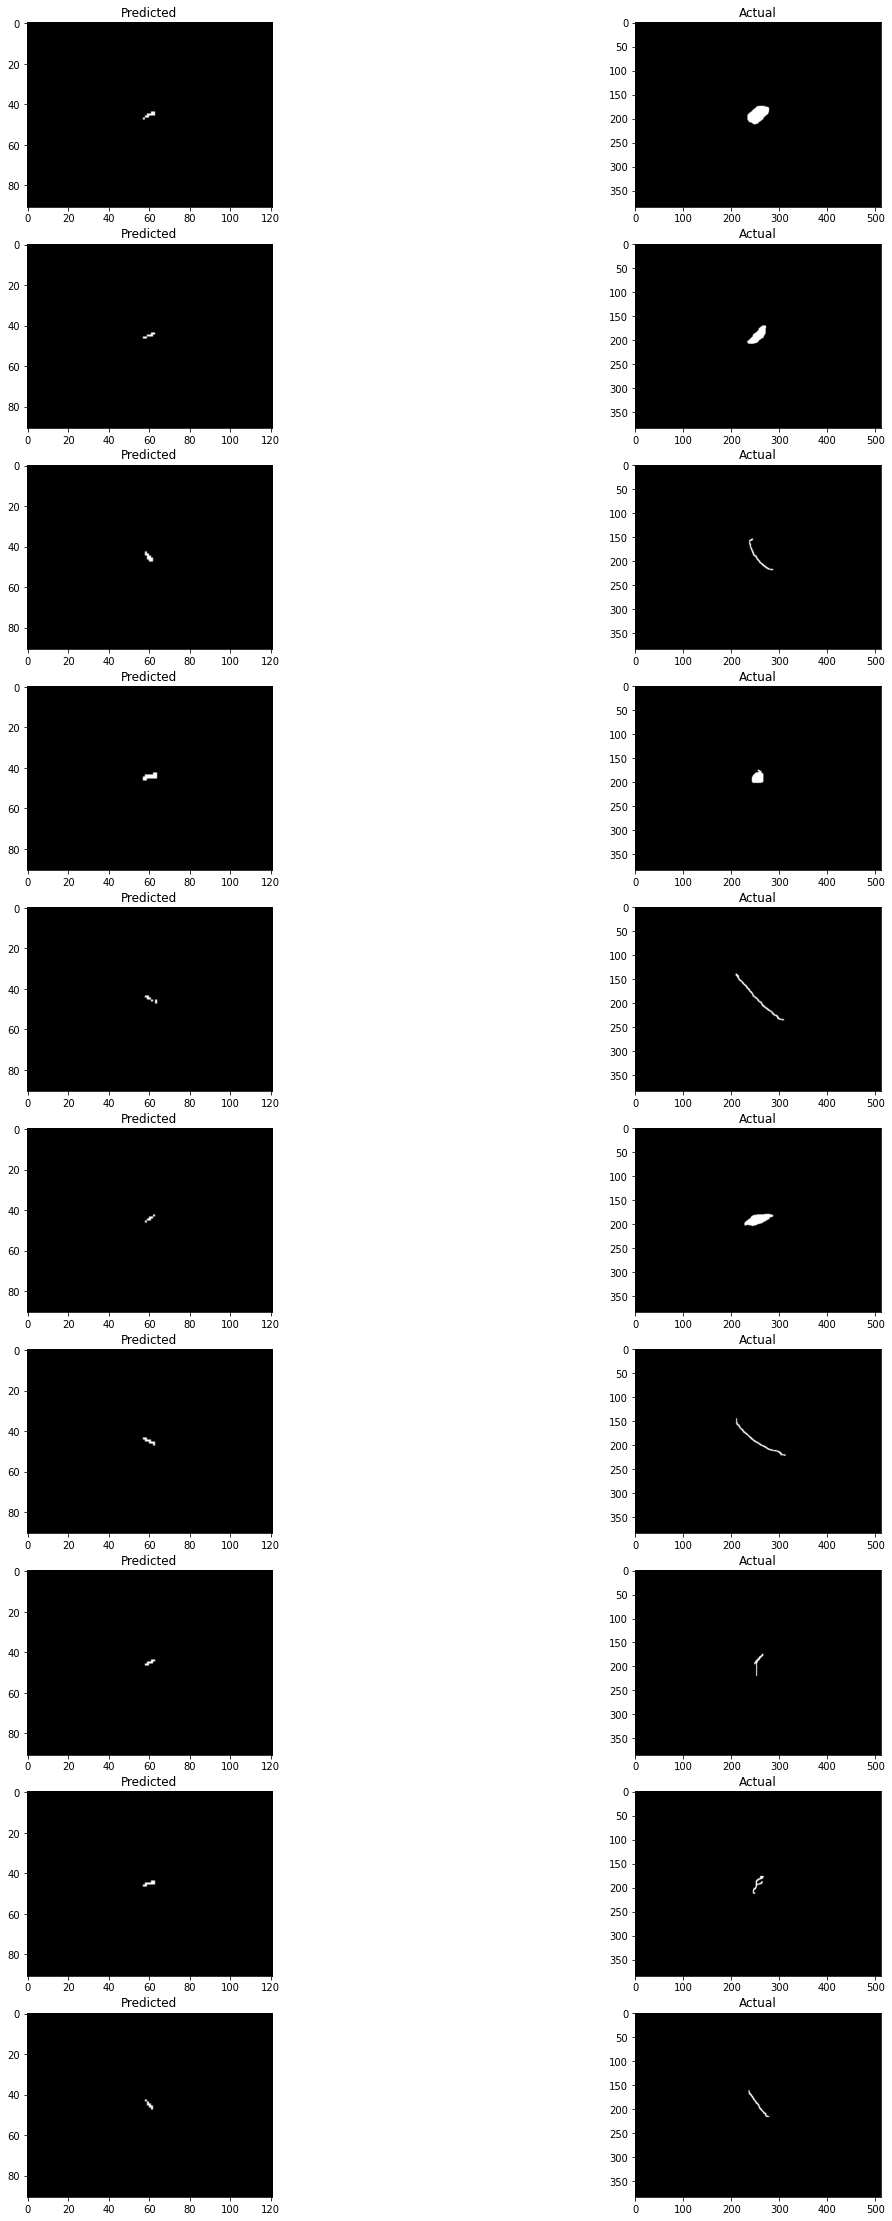

In [41]:
import random
from pulse2percept.utils import center_image
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
preds = estimator.predict(x)
for plt_idx, img_idx in enumerate(random.sample([i for i in range(len(x))], 10)):
    axes[plt_idx, 0].imshow(center_image(preds[img_idx] > 1), cmap="gray")
    axes[plt_idx, 0].set_title("Predicted")
    axes[plt_idx, 1].imshow(center_image(y[img_idx]), cmap='gray')
    axes[plt_idx, 1].set_title("Actual")
fig.show()

## AxonMap

In [ ]:
from pulse2percept.models import BiphasicAxonMapModel, AxonMapModel
from pulse2percept.model_selection import ParticleSwarmOptimizer
from pulse2percept.implants import ArgusII
import shapes

import matplotlib.pyplot as plt
import numpy as np

In [4]:
s2 = shapes.subject_params['12-005']
implant, model = shapes.model_from_params(s2, biphasic=False)
model.xystep=0.5

# CHANGING relative_weight will be VERY important
relative_weight=1e-5
estimator = shapes.AxonMapEstimator(implant=implant, model=model, relative_weight=relative_weight)
search_params = {
    'rho': (10, 1000),
    'axlambda': (10, 2000)
}
# search_params = {
#     'rho': (10, 300),
#     'axlambda': (10, 500)
# }
opt = ParticleSwarmOptimizer(estimator, search_params, max_iter=200, swarm_size=100, has_loss_function=True)

data = shapes.load_shapes("../data/shapes.h5", subjects=['12-005'], stim_class='SingleElectrode')
x = data[['amp1', 'freq', 'pdur', 'electrode1']]
y = data['image']


In [5]:
estimator.score(x, y)
opt.fit(x, y)

rho=200.000000, axlambda=200.000000, score=3.313693
rho=865.065426, axlambda=511.488464, score=736.317361
rho=623.359468, axlambda=1433.896854, score=441.032700
rho=52.309691, axlambda=1365.957181, score=3.348423
rho=513.345329, axlambda=1051.956610, score=172.017450
rho=345.337464, axlambda=578.350006, score=21.184348
rho=967.494666, axlambda=333.947320, score=1079.584845
rho=117.891668, axlambda=127.351093, score=3.353498
rho=527.337622, axlambda=1396.180390, score=258.374088
rho=266.646532, axlambda=1200.504484, score=27.303176
rho=411.059125, axlambda=1957.105768, score=193.508744
rho=522.416779, axlambda=538.924885, score=102.062989
rho=372.574419, axlambda=1008.836710, score=58.117108
rho=273.959778, axlambda=738.851658, score=12.676989
rho=827.729154, axlambda=997.756340, score=826.905911
rho=935.081598, axlambda=1412.794951, score=1573.976505
rho=575.998212, axlambda=966.455609, score=231.525601
rho=332.940614, axlambda=374.473690, score=11.701792
rho=542.691670, axlambda=1957.

KeyboardInterrupt: 